In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from poker_utils.hands import card_distance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

In [3]:
ev_data = pd.read_excel("data/raw/hand_ev_full.xlsx")

In [4]:
position_dummies = pd.get_dummies(ev_data['position'], prefix="dum", dtype=int)
ev_data = pd.concat([ev_data, position_dummies], axis=1)


In [5]:
ev_data['players_cat'] = pd.Categorical(ev_data['players'], ordered=True)
ev_data['position'] = pd.Categorical(ev_data['position'], 
               categories=["SB","BB","pos3",'pos4','pos5','pos6','pos7','pos8','pos9','D'], 
               ordered=True)

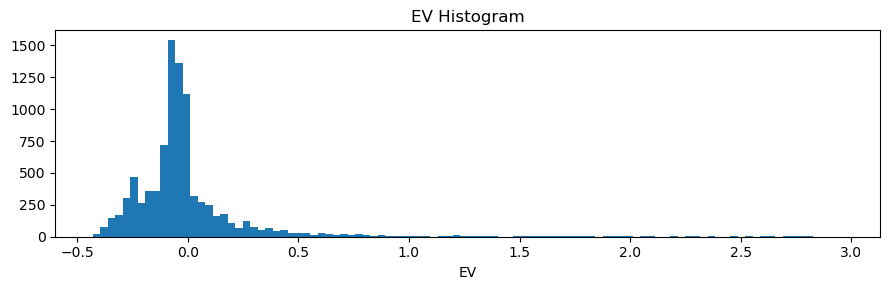

In [6]:
plt.figure(figsize=(9,3))
plt.hist(x=ev_data['EV'], bins=100)
plt.title("EV Histogram")
plt.xlabel("EV")
plt.tight_layout()
plt.show()

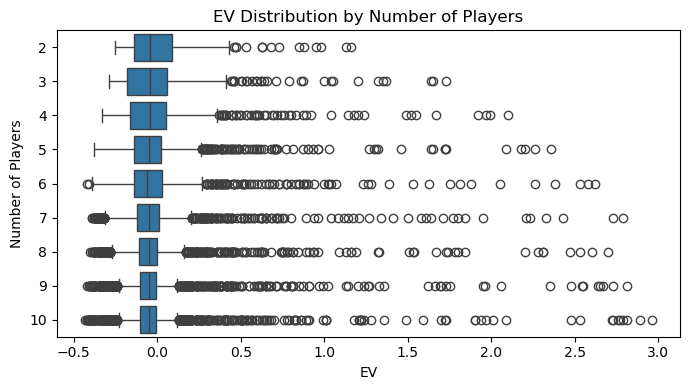

In [7]:
plt.figure(figsize=(7,4))
sns.boxplot(x='EV', y='players_cat', data=ev_data)
plt.title('EV Distribution by Number of Players')
plt.xlabel('EV')
plt.ylabel('Number of Players')
plt.tight_layout()
plt.show()

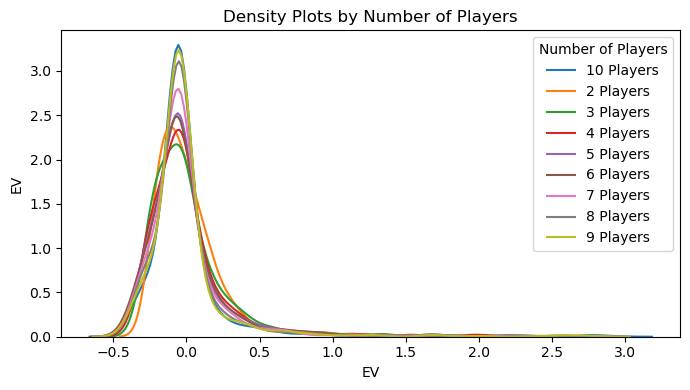

In [8]:
plt.figure(figsize=(7, 4))
for num_players in ev_data['players'].unique():
    sns.kdeplot(data=ev_data[ev_data['players'] == num_players], x='EV', label=f"{num_players} Players")
plt.title("Density Plots by Number of Players")
plt.ylabel("EV")
plt.legend(title="Number of Players")
plt.tight_layout()
plt.show()

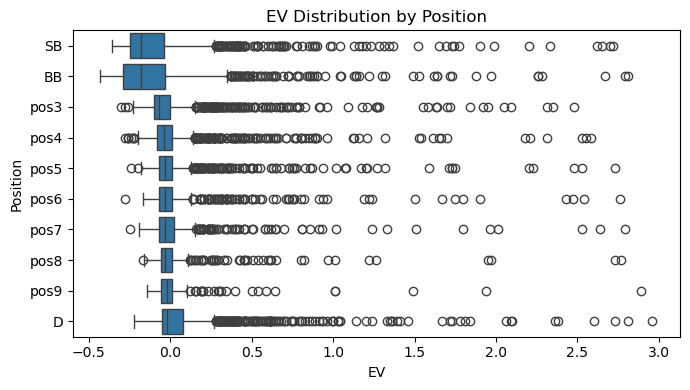

In [9]:
plt.figure(figsize=(7,4))
sns.boxplot(x='EV', y='position', data=ev_data)
plt.title('EV Distribution by Position')
plt.xlabel('EV')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

In [10]:
ev_data.groupby('players_cat', observed=False)['EV'].describe()

,count,mean,std,min,25%,50%,75%,max
players_cat,,,,,,,,
2,338.0,0.007485,0.221230,-0.25,-0.14,-0.040,0.09,1.16
3,507.0,0.006667,0.277942,-0.29,-0.18,-0.040,0.06,1.73
4,676.0,0.005888,0.301839,-0.33,-0.16,-0.045,0.05,2.10
5,845.0,0.000331,0.319333,-0.38,-0.14,-0.050,0.02,2.36
6,1014.0,-0.003008,0.322979,-0.42,-0.14,-0.060,0.03,2.62
7,1183.0,-0.004345,0.317576,-0.39,-0.12,-0.050,0.01,2.79
8,1352.0,-0.004534,0.311472,-0.40,-0.11,-0.050,0.00,2.70
9,1521.0,-0.004635,0.320438,-0.42,-0.10,-0.050,-0.01,2.81
10,1690.0,-0.002840,0.328860,-0.43,-0.10,-0.050,-0.01,2.96


In [11]:
ev_data.groupby('position', observed=False)['EV'].describe()

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
SB,1521.0,-0.087074,0.312930,-0.36,-0.25,-0.18,-0.0400,2.72
BB,1521.0,-0.100598,0.323569,-0.43,-0.29,-0.18,-0.0300,2.81
pos3,1183.0,0.012781,0.283622,-0.30,-0.10,-0.07,0.0000,2.48
pos4,1014.0,0.033974,0.288372,-0.28,-0.08,-0.04,0.0100,2.58
pos5,845.0,0.037290,0.294728,-0.24,-0.07,-0.03,0.0100,2.73
pos6,676.0,0.044112,0.301460,-0.28,-0.07,-0.03,0.0125,2.76
pos7,507.0,0.047554,0.314164,-0.25,-0.07,-0.03,0.0200,2.79
pos8,338.0,0.048639,0.318944,-0.17,-0.06,-0.03,0.0100,2.77
pos9,169.0,0.055444,0.332378,-0.14,-0.06,-0.02,0.0100,2.89


In [12]:
heatmap_data = ev_data.groupby(['players_cat','position'],observed=True)['EV'].mean().reset_index()\
    .pivot_table(values="EV",columns="position",index='players_cat', observed=True)

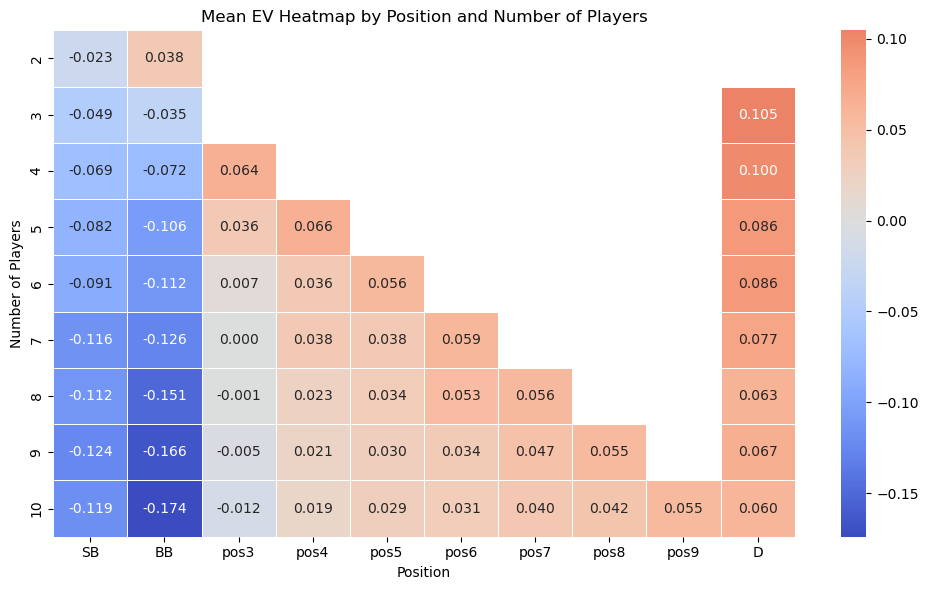

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.5, center=0)

plt.title("Mean EV Heatmap by Position and Number of Players")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.tight_layout()
plt.show()

In [14]:
def plot_hand_ev(hand, aggregate=False):
    ev_data[ev_data.hand==hand]
    plot_data = ev_data[ev_data.hand==hand].copy()
    
    plt.figure(figsize=(6, 4))
    if aggregate:
        plot_data = plot_data.groupby('players',observed=False)['EV'].mean().reset_index()
        sns.lineplot(plot_data, x='players',y='EV')
    else:
        for position in ev_data.position.unique():
            sns.lineplot(plot_data[plot_data.position == position], 
                     x='players', 
                     y='EV',
                     label=position)

    plt.title(f"EV for {hand}")
    plt.xlabel("Number of Players")
    plt.ylabel("EV")
    plt.tight_layout()
    plt.show()

In [15]:
ev_data['suited'] = (ev_data['hand'].str[-1] == 's')
ev_data['pair'] = (ev_data['hand'].str[0] == ev_data['hand'].str[1])
ev_data['connectedness'] = ev_data.apply(lambda x: card_distance(x.hand), axis=1)
ev_data['high_card'] = ev_data['hand'].apply(lambda x: '23456789TJQKA'.index(x[0]))
ev_data['low_card'] = ev_data['hand'].apply(lambda x: '23456789TJQKA'.index(x[1]))


In [16]:
ev_data['hand_type'] = np.select(
    condlist=[
        (ev_data['pair'] == True),
        (ev_data['suited'] == False),
        (ev_data['suited'] == True),
    ],
    choicelist=['pair', 'offsuit', 'suited'],
    default='other'
)

                            OLS Regression Results                            
Dep. Variable:                     EV   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     922.1
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:10:26   Log-Likelihood:                 1845.5
No. Observations:                9126   AIC:                            -3659.
Df Residuals:                    9110   BIC:                            -3545.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3742    

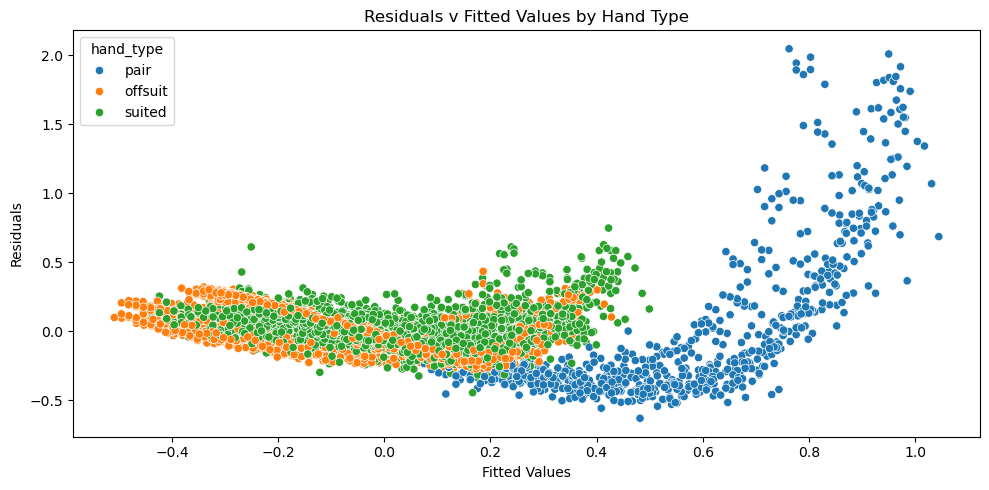

In [17]:
linear_model = smf.ols(
    formula=f'EV ~ players + position + connectedness + hand_type + low_card + high_card',
    data=ev_data).fit()
print(linear_model.summary())

ev_data['resid'] = linear_model.resid
ev_data['fittedvalues'] = linear_model.fittedvalues

plt.figure(figsize=(10,5))
sns.scatterplot(ev_data, x='fittedvalues', y='resid', hue='hand_type')
plt.title("Residuals v Fitted Values by Hand Type")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.tight_layout()
plt.show()

In [18]:
offsuit_df = ev_data[ev_data.hand_type=='offsuit'].copy()

                            OLS Regression Results                            
Dep. Variable:                     EV   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     520.0
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:10:27   Log-Likelihood:                 4135.1
No. Observations:                4212   AIC:                            -8242.
Df Residuals:                    4198   BIC:                            -8153.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1831      0.007  

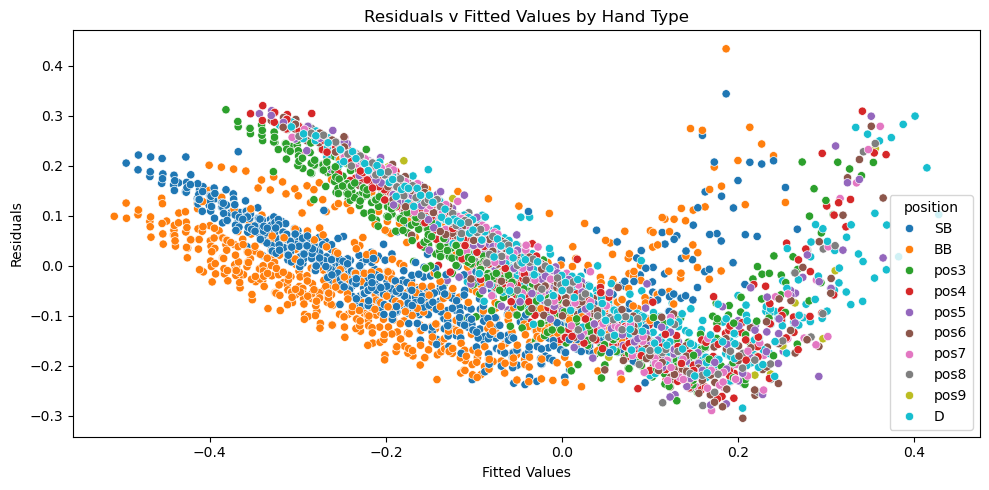

In [19]:
linear_model = smf.ols(
    formula=f'EV ~ players + position + connectedness + hand_type + low_card + high_card',
    data=offsuit_df).fit()
print(linear_model.summary())

ev_data['resid'] = linear_model.resid
ev_data['fittedvalues'] = linear_model.fittedvalues

plt.figure(figsize=(10,5))
sns.scatterplot(offsuit_df, x='fittedvalues', y='resid', hue='position')
plt.title("Residuals v Fitted Values by Hand Type")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.tight_layout()
plt.show()

In [20]:
X = ev_data[['position', 'hand_type', 'players', 'connectedness', 'high_card','low_card']]

In [21]:
X = pd.get_dummies(X, columns=['position'],prefix="pos")
X = pd.get_dummies(X, columns=['hand_type'],prefix="hand_type")
y = ev_data['EV']

In [22]:
X.head()

,players,connectedness,high_card,low_card,pos_SB,pos_BB,pos_pos3,pos_pos4,pos_pos5,pos_pos6,pos_pos7,pos_pos8,pos_pos9,pos_D,hand_type_offsuit,hand_type_pair,hand_type_suited
0,10,0,12,12,True,False,False,False,False,False,False,False,False,False,False,True,False
1,10,0,11,11,True,False,False,False,False,False,False,False,False,False,False,True,False
2,10,0,10,10,True,False,False,False,False,False,False,False,False,False,False,True,False
3,10,0,9,9,True,False,False,False,False,False,False,False,False,False,False,True,False
4,10,0,8,8,True,False,False,False,False,False,False,False,False,False,False,True,False


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

In [24]:
dt_model = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=29
)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                      random_state=29)

In [25]:
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

In [26]:
print(f"Training R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Testing R2: {r2_score(y_test, y_test_pred):.4f}")
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Testing MSE: {mean_squared_error(y_test, y_test_pred):.4f}")

Training R2: 0.9046
Testing R2: 0.9201
Training MSE: 0.0089
Testing MSE: 0.0095


In [27]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(importance)


Feature Importance:
              Feature  Importance
3            low_card    0.630582
1       connectedness    0.226770
15     hand_type_pair    0.038719
14  hand_type_offsuit    0.031449
4              pos_SB    0.026176
5              pos_BB    0.021764
0             players    0.013760
2           high_card    0.010779
6            pos_pos3    0.000000
8            pos_pos5    0.000000
7            pos_pos4    0.000000
9            pos_pos6    0.000000
10           pos_pos7    0.000000
12           pos_pos9    0.000000
11           pos_pos8    0.000000
13              pos_D    0.000000
16   hand_type_suited    0.000000


In [28]:
ev_data = pd.read_excel('data/raw/hand_ev_full.xlsx')

In [29]:
ev_data['pos_player'] = ev_data['position'] + "_play" +ev_data['players'].astype(str)

In [30]:
ev_matrix = ev_data.pivot(
    index='hand',
    columns='pos_player',
    values='EV'
)

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ev_matrix)

In [32]:
pca = PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.94748006 0.02282001 0.00435172]


In [33]:
ev_matrix['pc1'] = X_pca[:,0]
ev_matrix['pc2'] = X_pca[:,1]
ev_matrix['pc3'] = X_pca[:,2]

C:\Users\campb\AppData\Local\Temp\ipykernel_10376\833907572.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ev_matrix['pc1'][i], ev_matrix['pc2'][i], ev_matrix['pc3'][i], hand)


Text(0.5, 0.92, '3 Component PCA')

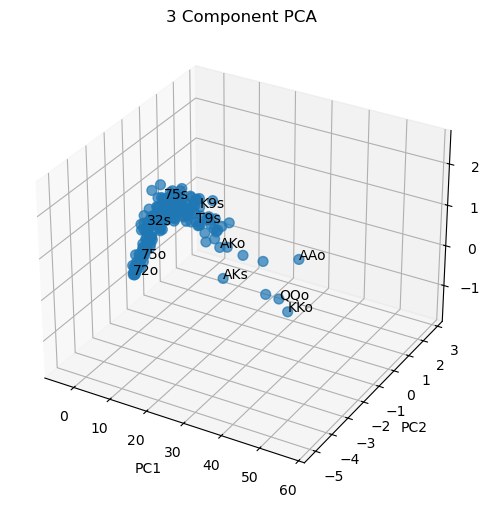

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    ev_matrix['pc1'], 
    ev_matrix['pc2'], 
    ev_matrix['pc3'],
    s=50, 
    alpha=0.7  
)
for i, hand in enumerate(ev_matrix.index):
    if hand in ['AAo', 'KKo', 'AKs', 'QQo', '72o', 'T9s', 'AKo', '75s','75o','K9s','32s']:
        ax.text(ev_matrix['pc1'][i], ev_matrix['pc2'][i], ev_matrix['pc3'][i], hand)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3 Component PCA')

In [35]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.94748006 0.02282001]


In [36]:
ev_matrix['ev_pc1'] = X_pca[:,0]
ev_matrix['ev_pc2'] = X_pca[:,1]
ev_matrix.drop(['pc3','pc1','pc2'], axis=1, inplace=True)

In [37]:
ev_matrix.reset_index(inplace=True)

In [38]:
ev_matrix['suited'] = (ev_matrix['hand'].str[-1] == 's')
ev_matrix['pair'] = (ev_matrix['hand'].str[0] == ev_matrix['hand'].str[1])

ev_matrix['hand_type'] = np.select(
    condlist=[
        (ev_matrix['pair'] == True),
        (ev_matrix['suited'] == False),
        (ev_matrix['suited'] == True),
    ],
    choicelist=['pair', 'offsuit', 'suited'],
    default='other'
)

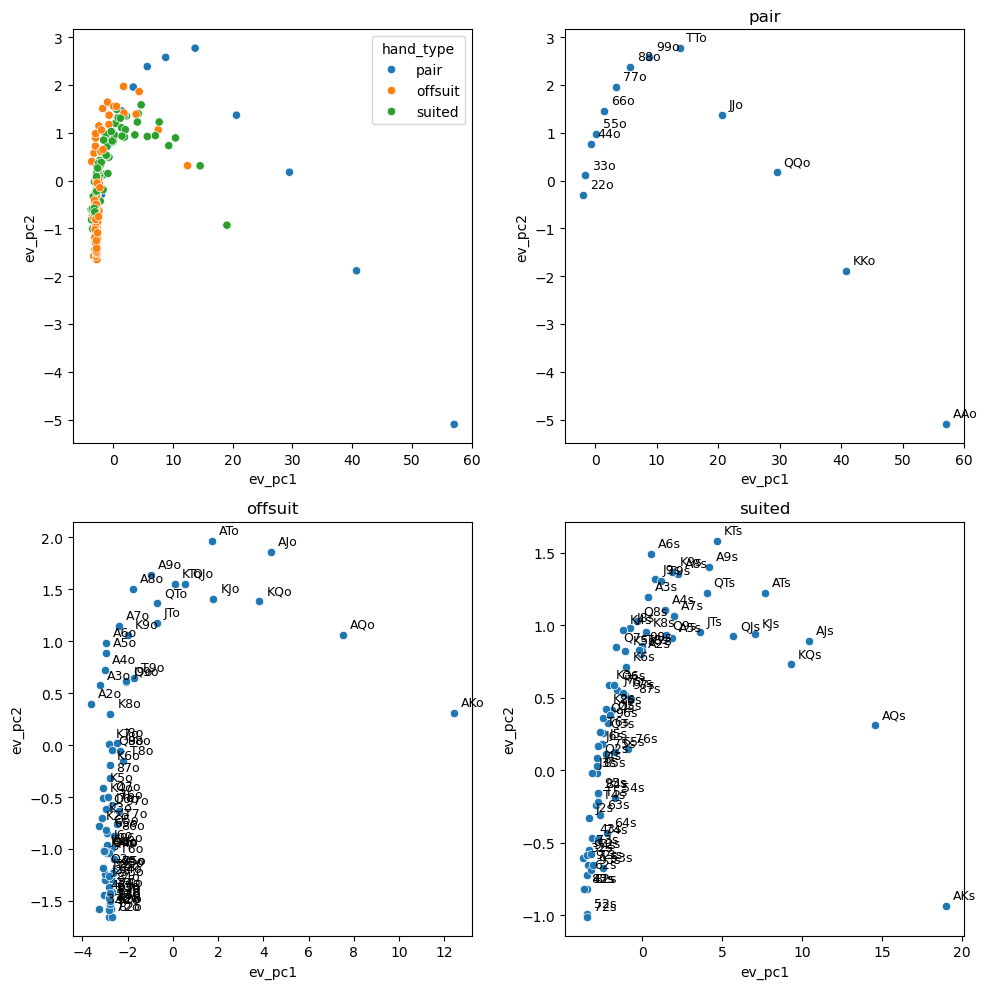

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=ev_matrix, x='ev_pc1', y='ev_pc2', hue='hand_type', ax=axs[0,0])\

hand_types = ev_matrix['hand_type'].unique()
for i, ax in enumerate(axs.flatten()[1:]):
    hand_type = hand_types[i]
    filtered_data = ev_matrix[ev_matrix['hand_type'] == hand_type]
        
    sns.scatterplot(data=filtered_data, x='ev_pc1', y='ev_pc2', ax=ax)
    ax.set_title(f'{hand_type}')
        
    for j, hand in enumerate(filtered_data['hand']):
        x_coord = filtered_data.iloc[j]['ev_pc1']
        y_coord = filtered_data.iloc[j]['ev_pc2']
        ax.annotate(
               hand,
            (x_coord, y_coord),
            fontsize=9,
            xytext=(5, 5),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

In [41]:
ev_matrix.drop(['suited','pair','hand_type'],axis=1, inplace=True)

In [42]:
ev_matrix.to_csv("data/raw/ev_pca_data.csv", index=False)